# Глава 1. Полносвязные нейронные сети

## Часть 4. Тонкая настройка нейронной сети

* Batch Normalization

* Инициализация весов

* Регуляризация (l2 и дропаут)

* Функция активации ReLu для борьбы с затуханием градиента

* Использование ансамбля нейросетей (для самостоятельной проработки)

* Использованием стэкинга нейросетей (для самостоятельной проработки)

## 1. Задача классификации

Воспользуемся тестовым примером, два класса, имеюшие форму концентрических окружностей. Функция позволяет создавать вариации датасета с разным уровнем шума.

Это хорошая тестовая задача, потому что классы не линейно разделимы, что требует нелинейного метода, такого как нейронная сеть

In [43]:
from sklearn.datasets import make_circles

In [44]:
from numpy import where
from matplotlib import pyplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [45]:
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)

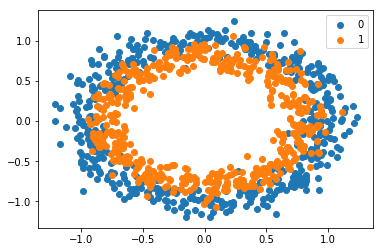

In [46]:
for i in range(2):
    samples_ix = where(y == i)
    pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1], label=str(i))
pyplot.legend()
pyplot.show()

##  2.1 Многослойный перцептрон

Попробуем модель многослойного перцептрона (MLP) в качестве основной модели для решения этой задачи.

Сначала мы разделим 1000 сгенерированных семплов данных для обучения и тестирования по 500 примеров в каждом. Это обеспечит достаточно большую выборку для обучения модели и достаточно справедливую оценку ее эффективности.

Модель будет иметь один скрытый слой с 50 нейронами и использовать ReLu функцию активации и метод инициализации начальных весов He (Ге). Выходным слоем будет отдельный узел с функцией активации сигмоида. При этом выход модели можно интерпретировать как вероятность принадлежности к классу 1.

Модель будет обучаться использованием стохастического градиентного спуска с небольшой скоростью обучения 0,01 и большим импульсом 0,9. В качестве функции потерь будем использовать бинарную кросс-энтропию.

In [47]:
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

In [48]:
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [49]:
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

In [50]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)

In [52]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)

In [53]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.840, Test: 0.850


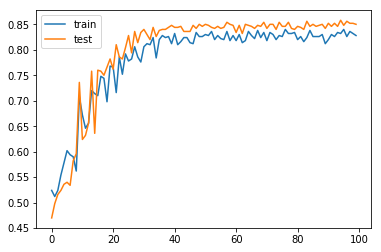

In [54]:
# plot history
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

## 2.2 MLP с BatchNormalization

**Бэтч нормализация** - это метод нормализации (стандартизации) внутреннего представления данных для ускорения обучения.

* Метод решает следующую проблему, препятствующую эффективному обучению нейронных сетей

* По мере распространения сигнала по сети, даже если мы нормализовали его на входе, пройдя через внутренние слои, он может сильно исказиться как по матожиднию, так и по дисперсии (данное явление называется внутренним ковариационным сдвигом), что чревато серьезными несоответствиями между градиентами на различных уровнях. Из-за этого нам приходится использовать более сильные регуляризаторы, замедляя тем самым темп обучения.

**Батч-нормализация** -предлагает весьма простое решение данной проблемы: нормализовать входные данные таким образом, чтобы получить нулевое матожидание и единичную дисперсию. 

Нормализация выполняется перед входом в каждый слой. Это значит, что во время обучения мы нормализуем batch_size примеров, а во время тестирования мы нормализуем статистику, полученную на основе всего обучающего множества, так как увидеть заранее тестовые данные мы не можем.

![title](img/ann23.png)

Обновим модель с добавлением бэтч нормализации

Ожидается, что добавление нормализации бэтча ускорит процесс обучения, обеспечивая аналогичную или лучшую точность классификации модели в меньшем количестве эпох обучения. 

Бэтч нормализация обеспечивает слабую форму регуляризации, что означает, что она может также предложить небольшое снижение ошибки обобщения, продемонстрированное небольшим увеличением точности классификации в наборе тестовых данных.

Новый слой BatchNormalization можно добавить в модель после скрытого слоя перед выходным слоем. В частности, после активации функции предыдущего скрытого слоя.

In [55]:
from keras.layers import BatchNormalization

In [56]:
# define model
model = Sequential()
model.add(Dense(50, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)

In [58]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)

In [59]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.842, Test: 0.846


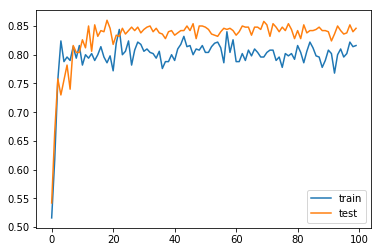

In [60]:
# plot history
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

### Задание 1. 
* C бетой и гаммой. Обновите пример, чтобы посмотреть как влияют бета- и гамма-параметры в слое бэтч нормализации. Сравните результаты.

* С импульсом  (momentum). Обновите пример, чтобы посмотреть как влияет импульс в слое бэтч нормализации во время обучения. Сравните результаты.

* Входной слой. Обновите пример, чтобы использовать бэтч нормализацию после входных параметров в модели. Сравнить результаты.

Литература

Sergey Ioffe, Christian Szegedy.  Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (https://arxiv.org/abs/1502.03167)

## 3. Регуляризация для нейронных сетей

## 3.1 MLP без регуляризации Dropout

* Главная идея Dropout — вместо обучения одной DNN обучить ансамбль нескольких DNN, а затем усреднить полученные результаты.

* Сети для обучения получаются с помощью исключения из сети (dropping out) нейронов с вероятностью , таким образом, вероятность того, что нейрон останется в сети, составляет . “Исключение” нейрона означает, что при любых входных данных или параметрах он возвращает 0.

* Исключенные нейроны не вносят свой вклад в процесс обучения ни на одном из этапов алгоритма обратного распространения ошибки (backpropagation); поэтому исключение хотя бы одного из нейронов равносильно обучению новой нейронной сети.

* В двух словах, Dropout хорошо работает на практике, потому что предотвращает взаимоадаптацию нейронов на этапе обучения.

![title](img/ann19.jpeg)

In [85]:
import pandas as pd

In [86]:
X, y = make_circles(n_samples=100, noise=0.1, random_state=1)

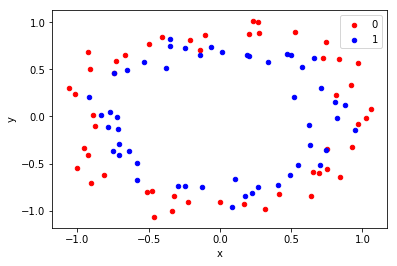

In [87]:
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [88]:
X, y = make_circles(n_samples=100, noise=0.1, random_state=1)

n_train = 30
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

In [89]:
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=1)

In [91]:
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 1.000, Test: 0.771


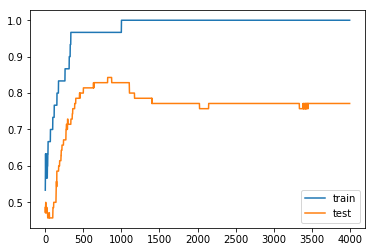

In [92]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

### 3.2 MLP c dropout регуляризацией

In [93]:
from keras.layers import Dropout

In [94]:
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [95]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0)

In [96]:
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.967, Test: 0.800


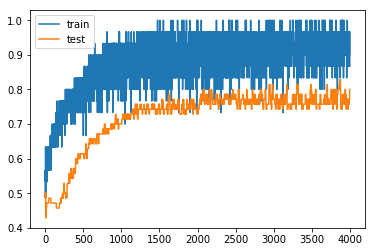

In [97]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

### Задание 2.

* Ограничение веса. Обновите пример, чтобы добавить l2-регуляризациб в скрытый слой и сравните результаты.

* Повторная оценка. Обновите пример, чтобы повторить оценку модели избыточного снаряжения и отсева, суммировать и сравнивать средние результаты.

* Перебор по сетке. Определить зависимость вероятности в функции dropout от величины значения на тестовой выборке

## 4. Проблема исчезающих и взрывающихся градиентов

Проблема исчезающих градиентов является примером нестабильного поведения, с которым вы можете столкнуться при обучении глубокой нейронной сети.

* Он описывает ситуацию, когда глубокая многослойная сеть с прямой связью или рекуррентная нейронная сеть не в состоянии распространять полезную информацию о градиенте от выходного конца модели обратно к слоям около входного конца модели.

* Результатом является общая неспособность моделей со многими слоями учиться на заданном наборе данных или преждевременно сходиться к плохому решению.

* Многие исправления и обходные пути были предложены и исследованы, такие как альтернативные схемы инициализации веса, неконтролируемая предварительная подготовка, послойное обучение и изменения алгоритма градиентного спуска. 

* Возможно, наиболее распространенным изменением является использование функции линейной активации ReLu, которая стала новым must have, вместо функции активации гиперболического тангенса, которая была популярна в конце 1990-х и 2000-х годов.

Мы разберем как увидеть проблему исчезающего градиента при обучении модели нейронной сети и как ее исправить, используя альтернативную функцию активации ReLu и схему инициализации веса.

![title](img/ann24.png)

Рассмотрим нейронную сеть с 4 скрытыми слоями с одним нейроном в каждой матрице.

![title](img/ann25.png)

**Вычислительный граф** для такой сети выглядит следующим образом. 

При прямом распространении мы просто умножаем входные данные на матрицы весов и добавляем смещение, как показано выше. Затем берем сигмоидальную функцию активации

![title](img/ann26.png)

Во время  обратного распространения ошибки (backprop) мы находим производную от выхода по весам сети, чтобы уточнить результат модели. Предположим, что мы хотим найти производную матрицы весов C по b1

Условия, которые будут включены в это:

![title](img/ann27.png)

sig'(z1), sig' (z2) .. и т. д. меньше 1/4.  Потому что производная сигмоидальной функции составляет менее 1/4.

* Матрицы весов w1, w2, w3, w4 инициализируются из нормального распределения, чтобы иметь среднее значение 0 и стандартное отклонение 1. Следовательно, ||w|| меньше 1. 

* Следовательно, в производной мы умножаем множество членов, которые меньше 1 и 1/4. Следовательно, при умножении таких маленьких множителей большое количество раз мы получаем очень маленький градиент, из-за которого обучение может остановиться.

![title](img/ann25.png)

Похожая ситуация с **взрывающимися градиентами.** Если мы инициализируем наши матрицы весов очень большими значениями, то производная будет очень большой, и, следовательно, может наблюдаться нестабильное поведение при обучении

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
# generate 2d classification dataset
X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)
# scale input data to [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [20]:
from keras.initializers import RandomUniform

In [21]:
# define model
model = Sequential()
init = RandomUniform(minval=0, maxval=1)
model.add(Dense(5, input_dim=2, activation='tanh', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

In [22]:
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [23]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

In [24]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.820, Test: 0.836


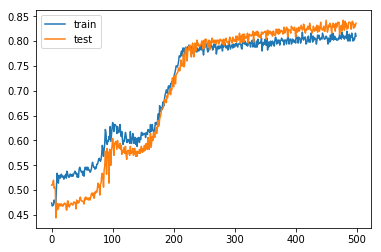

In [25]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()

## 4.1 Более глубокий  MLP

In [26]:
init = RandomUniform(minval=0, maxval=1)
model = Sequential()
model.add(Dense(5, input_dim=2, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(5, activation='tanh', kernel_initializer=init))
model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

In [27]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [28]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)

In [29]:
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.582, Test: 0.550


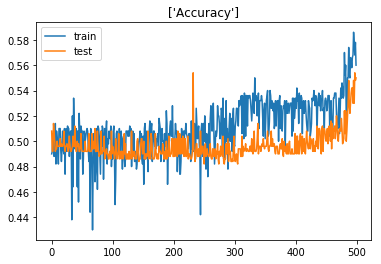

In [30]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
plt.title(["Accuracy"])
pyplot.legend()
pyplot.show()

## 4.2 Глубокий MLP с ReLu

### 4.2.1. Преимущества ReLu

ReLU является линейным для всех положительных значений и нулем для всех отрицательных значений. Это означает, что:

* Просто с вычислительной точки зрения. Таким образом, модели может потребоваться меньше времени для обучения.

* Быстрее сходимость. Линейность означает, что наклон не является плато или промежутком насыщения, когда x становится большим. 

* У ReLu нет проблемы исчезающего градиента, от которой страдают другие функции активации, такие как сигмоид или гиперболический тангес.

* Поскольку ReLU равен нулю для всех отрицательных входов. Производная также равна нулю. Бороться с этой проблемой, мы можем использовать негерметичный ReLU. Leaky ReLU гарантирует, что наклон для отрицательных значений не равен нулю.

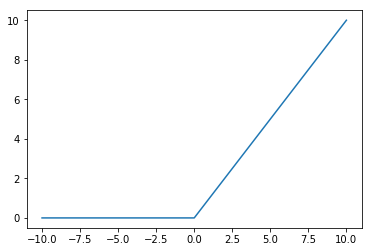

In [31]:
 # rectified linear function
def rectified(x):
    return max(0.0, x)
 
# define a series of inputs
series_in = [x for x in range(-10, 11)]
# calculate outputs for our inputs
series_out = [rectified(x) for x in series_in]
# line plot of raw inputs to rectified outputs
pyplot.plot(series_in, series_out)
pyplot.show()

### 4.2.2 Инициализация весов

**Метод инициализации Завьера (Xavier)** (иногда — метод Glorot’а). 

Основная идея этого метода — упростить прохождение сигнала через слой во время как прямого, так и обратного распространения ошибки для линейной функции активации (этот метод также хорошо работает для сигмоидной функции, так как участок, где она ненасыщена, также имеет линейный характер).

При вычислении весов этот метод опирается на вероятностное распределение (равномерное или нормальное) с дисперсией $$Var(W)= {2 \over n_{in} + n_{out}}$$, где n количества нейронов в предыдущем и последующем слоях соответственно.

**Метод инициализации Ге (He)** — это вариация метода Завьера, больше подходящая функции активации ReLU, компенсирующая тот факт, что эта функция возвращает нуль для половины области определения. А именно, в этом случае $$\mathrm{Var}(W) = {2 \over{n_{in}}}$$

In [32]:
model = Sequential()
model.add(Dense(5, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(5, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

In [33]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=1)

In [35]:
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.848, Test: 0.826


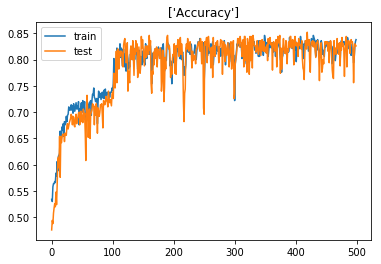

In [36]:
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
plt.title(["Accuracy"])
pyplot.legend()
pyplot.show()

In [37]:
from keras.callbacks import TensorBoard

In [38]:
tb = TensorBoard(histogram_freq=1, write_grads=True)

In [39]:
model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0, callbacks=[tb])

### Задание 3.

* Инициализация начальных весов. Обновите MLP, сделайте функцию активации tanh, чтобы использовать инициализацию Xavier с равномерным весом. Опишите результаты.

* Алгоритм обучения. Обновите MLP, сделайте функцию активации tanh, чтобы использовать алгоритм адаптивного обучения, такой как Адам. Опишите  результаты.

* Изменения веса. Повторите примеры с tanh и relu, чтобы записать и построить векторную норму L1 весов моделей для каждой эпохи в качестве показателя того, насколько каждый слой изменяется во время обучения. Сравните результаты

* Увеличение глубины модели. Реализуйте эксперимент, используя MLP с tanh активацией. Покажите производительность моделей при увеличении количества скрытых слоев с 1 до 10.

* Увеличьте ширину сети. Увеличьте количество нейронов в скрытых слоях MLP с tanh активации с 5 до 25 и покажите  производительность при увеличении количества слоев с 1 до 10.

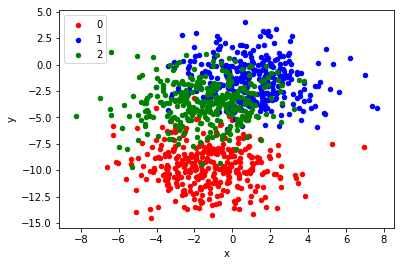

In [101]:
from sklearn.datasets.samples_generator import make_blobs
from matplotlib import pyplot
from pandas import DataFrame


X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

## 5. Ансамбль нейросетей

In [123]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from itertools import product

In [124]:
def fit_model(trainX, trainy):
    trainy_enc = to_categorical(trainy)
    # инициализируем модель
    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # обучение модели
    model.fit(trainX, trainy_enc, epochs=500, verbose=0)
    return model
 
# делаем прогноз для ансамбля моделей
def ensemble_predictions(members, weights, testX):
    # делаем прогнозы отдельными моделями
    yhats = [model.predict(testX) for model in members]
    yhats = array(yhats)
    # взвешенная сумма моделей в ансамбле
    summed = tensordot(yhats, weights, axes=((0),(0)))
    # argmax по классам
    result = argmax(summed, axis=1)
    return result
 
# вычисление прогноза для ансамбля моделей
def evaluate_ensemble(members, weights, testX, testy):
    # формируем прогнозы
    yhat = ensemble_predictions(members, weights, testX)
    # вычисляем точность (accuracy)
    return accuracy_score(testy, yhat)
 
# нормализация векторов весов, чтобы норма = 1
def normalize(weights):
    # вычисление l1 нормы 
    result = norm(weights, 1)
    # проверка на нули
    if result == 0.0:
        return weights
    # возвращем нормализованный вектор коэффициентов
    return weights / result
 
# поиск оптимальных весов перебором по сетке
def grid_search(members, testX, testy):
    # определяем веса
    w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    best_score, best_weights = 0.0, None
    # перебираем все возможные комбинации
    for weights in product(w, repeat=len(members)):
        # пропускаем, если все веса равны
        if len(set(weights)) == 1:
            continue
        # нормализация весов
        weights = normalize(weights)
        # расчет весов
        score = evaluate_ensemble(members, weights, testX, testy)
        if score > best_score:
            best_score, best_weights = score, weights
            print('>%s %.3f' % (best_weights, best_score))
    return list(best_weights)

In [125]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# разбиваем на обучение и тест
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


In [ ]:
# обучение моделей
n_members = 5
members = [fit_model(trainX, trainy) for _ in range(n_members)]
# расчет для каждой модели в ансамбле
testy_enc = to_categorical(testy)
for i in range(n_members):
    _, test_acc = members[i].evaluate(testX, testy_enc, verbose=0)
    print('Model %d: %.3f' % (i+1, test_acc))
# вычисление среднего ансамбля
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, testX, testy)
print('Equal Weights Score: %.3f' % score)
# поиск оптимальных весов перебором по сетке
weights = grid_search(members, testX, testy)
score = evaluate_ensemble(members, weights, testX, testy)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

##  6. Stacking нейросетей


In [140]:
from sklearn.datasets.samples_generator import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from os import makedirs

def fit_model(trainX, trainy):

    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(trainX, trainy, epochs=500, verbose=0)
    return model

In [141]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


In [142]:
#makedirs('models')
n_members = 5
for i in range(n_members):
    model = fit_model(trainX, trainy)
    filename = 'models/model_' + str(i + 1) + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)

>Saved models/model_1.h5
>Saved models/model_2.h5
>Saved models/model_3.h5
>Saved models/model_4.h5
>Saved models/model_5.h5


In [143]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax
import pydot 
import graphviz

In [144]:
# загрузка моделей из файла
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'models/model_' + str(i + 1) + '.h5'
        # загрузка модели из файла
        model = load_model(filename)
        # добавка списка моделей в ансамбле
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models
 
# определение модели стекинга
def define_stacked_model(members):
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            layer.trainable = False
            layer.name = 'ensemble_' + str(i+1) + '_' + layer.name
    # определение множественного входа
    ensemble_visible = [model.input for model in members]
    # объединение выхода из каждой модели
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(3, activation='softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # вывод графика стэкинга
    plot_model(model, show_shapes=True, to_file='model_graph.png')
    # компиляция
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# обучение модели стекинга
def fit_stacked_model(model, inputX, inputy):
    # подгоовка входных данных
    X = [inputX for _ in range(len(model.input))]
    inputy_enc = to_categorical(inputy)
    # обучение модели
    model.fit(X, inputy_enc, epochs=300, verbose=0)
    
def predict_stacked_model(model, inputX):
    # подготовка входных данных
    X = [inputX for _ in range(len(model.input))]
    # делаем предикт
    return model.predict(X, verbose=0)

In [145]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
# разбиваем на обучение и тест
n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
print(trainX.shape, testX.shape)

(100, 2) (1000, 2)


#### Комментарий: Установите pydot и graphviz для визуализации структуры нейронной сети, либо отключите функцию plot_model

In [ ]:
# загрузка всех моделей
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# определение стекинга моделей
stacked_model = define_stacked_model(members)
# обучение модели стекинга
fit_stacked_model(stacked_model, testX, testy)
# предикт модели стекинга
yhat = predict_stacked_model(stacked_model, testX)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(testy, yhat)
print('Stacked Test Accuracy: %.3f' % acc)

### Задание 4. 
* Разобраться с ансамблями и стекингом.
* Применить для своей задачи классификации.